# Langevin Dynamics #


In lecture this week, we introduced the concept of *macroscopic* observables: ensemble averages of microscopic observables over all microstates consistent with a given set of macroscopic constraints. Modeling macroscopic properties numerically can be taxing. In principle, we *could* try to calculate the bulk properties of a glass of water using a macroscopic number ($\sim10^{23}$) of particles, but in practice real computers can't even store all the necessary data, let alone run the simulation. 

### MD Thermostats ###

To get around this problem, computational chemists have constructed a variety of methods designed to run an MD simulation with a *small* number of particles that behave as though they're interacting with a much larger number of particles. MD *thermostats*, for example, stabilize the average kinetic energy of particles in an MD simulation -- a proxy for the macroscopic temperature. Similarly, *barostats* stabilize the average pressure exerted by the particles running into the simulation box walls. In this exercise, we'll implement a simple thermostat using *Langevin dynamics*, an extension of molecular dynamics in which each particle feels (in addition to forces from other simulation particles) randomly-generated forces that simulate interaction with a large number of "solvent" particles whose microscopic coordinates aren't explicitly included in the simulation. 

### Langevin Dynamics for Solvation ###

Langevin dynamics originated in the study of Brownian motion -- the diffusion of mesoscopic particles (like pollen grains) in a solvent. A key assumption in the Langevin treatment is that the solvent particle is much larger than the solute molecules around it. As a result of that difference in scale, a careful theory can be worked out that allows us to explicitly follow the coordinates and momenta of the solute molecule, while treating the solvent molecules implicitly through their influence on the solvent particles. For a single solute particle, the Langevin equation reads
\begin{align}
M \ddot {\bf r}(t) &= {\bf F}({\bf r},t) - \gamma \dot {\bf r} + {\bf \xi}(t).
\end{align}
In the absence of the last two terms, this would simply be Newton's equation: ${\bf F} = M {\bf a}$. Here ${\bf F}({\bf r},t)$ is the deterministic force (if any) the particle would feel in the absence of interactions with the solvent. The last two terms represent (in an approximate way) the impact of the solvent on the solute dynamics. The $- \gamma \dot {\bf r}$ is proportional to the particle velocity ${\bf v} = - \gamma \dot {\bf r}$ and describes the *viscous drag* or friction that the solute particle experiences as a result of constantly running into solvent molecules. The second term, ${\bf \xi}(t)$ is a random force that represents the constantly-fluctuating force exerted on the particle by the surrounding solvent: sometimes the particle gets "kicked" up, sometimes down, sometimes left, sometimes right, all depending on the microscopic trajectories of the solvent molecules around it. Since we don't want to actually *calculate* all those microscopic solvent trajectories, the force ${\bf \xi}(t)$ in our simulation will be a random variable. Because the microscopic configuration of the solvent is assumed to change much more quickly than the position of the solute particle, the random force ${\bf \xi}(t)$ is taken to be *delta-correlated*, i.e., the value of the force at different time points $t_1$ and $t_2$ are assumed to be statistically independent of each other. For thermodynamic consistency, it can then be shown that the random force must satisfy the *fluctuation-dissipation relation* 
\begin{align}
\left \langle {\bf \xi}(t_2) {\bf \xi}(t_1) \right \rangle = 2 \gamma k_B T \delta(t_2 - t_1)
\end{align}
for any two time points $t_1$ and $t_2$. Of course, the assumption of a delta-correlated random force is an approximation. In the real world, there should always be *some* time scale (perhaps very short) over which the solvent forces remain correlated at different time points. For this reason, a key limitation to Langevin dynamics is that we only study dynamics on time scales *much longer* than this solvent correlation time. 

The numerical implementation of Langevin dynamics is slightly more complicated than plain-vanilla MD (mostly due to the appearance of the delta function in the noise correlation). For this simulation, we'll use an adapted Velocity-Verlet like algorithm published here: *Molecular Physics*, **111**, 983–991 (2013). You aren't responsible for understanding or coding the algorithm -- you'll just have to run the code -- although as usual you're encouraged to have a look anyway. Areas with major changes are marked by comment headings. After looking through the code, modify parameters to answer the questions in the text below it. 

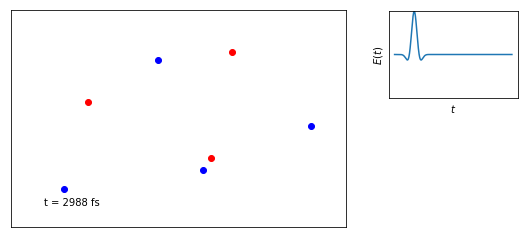

In [1]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time

import numpy as np

def calc_accel(x,y,efield):
    ax = 4*epso*(Ro**4)/(M*x**5) - 4*epso*(Ro**4)/(M*(L-x)**5)
    ay = 4*epso*(Ro**4)/(M*y**5) - 4*epso*(Ro**4)/(M*(L-y)**5)
    for p1 in range(0, Npart):
        for p2 in range(0,Npart):
            if p1!=p2:
                rX = x[p1] - x[p2]
                rY = y[p1] - y[p2]
                r = math.sqrt(rX*rX + rY*rY)
                ax[p1] += Q[p1]*Q[p2]*rX/(M*r**3)
                ay[p1] += Q[p1]*Q[p2]*rY/(M*r**3)
                ax[p1] += 12.0*epso*rX*(Ro**12)/(M*r**14) - 12.0*epso*rX*(Ro**6)/(M*r**8)
                ay[p1] += 12.0*epso*rY*(Ro**12)/(M*r**14) - 12.0*epso*rY*(Ro**6)/(M*r**8)
    ay += Q*efield/M
    return ax,ay
    
#############################
######## Main Changes #######
#############################

def vv_step(x,y,vx,vy,ax,ay,efield):
    axrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart))/M
    ayrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart))/M
    xnew = x + B*dt*vx + 0.5*B*dt*dt*(ax + axrand)
    ynew = y + B*dt*vy + 0.5*B*dt*dt*(ay + ayrand)
    axnew,aynew = calc_accel(xnew,ynew,efield)
    vxnew = A*vx + 0.5*dt*(A*ax + axnew + 2.0*B*axrand)
    vynew = A*vy + 0.5*dt*(A*ay + aynew + 2.0*B*ayrand)
    return xnew,ynew,vxnew,vynew,axnew,aynew

##############################
##############################

def init_plot():
    fig = plt.figure(1)
    ax1 = plt.clf()
    txt = plt.text(0.1*L,0.1*L,'t = '+str(round(0))+' fs')
    negLine, = plt.plot(X[0:Npos],Y[0:Npos],'bo')
    posLine, = plt.plot(X[Npos:],Y[Npos:],'ro')
    plt.xlim([0,L])
    plt.ylim([0,L])
    plt.xticks([]) 
    plt.yticks([]) 
    
    ax2 = plt.axes([1.0,0.575,0.3,0.3])
    plt.xlabel('$t$')
    plt.ylabel('$E(t)$')
    field_line, = plt.plot(taxis,Efield)
    plt.xticks([])
    plt.yticks([])
    plt.ylim([0,1])
    plt.ylim([0,dt*Nsteps])
    return fig,ax1,ax2,negLine,posLine,txt,field_line

def update_plot(n):
    negPts.set_ydata(Y[0:Npos])
    negPts.set_xdata(X[0:Npos])
    posPts.set_ydata(Y[Npos:])
    posPts.set_xdata(X[Npos:])
    txt.set_text('t = '+str(round(n*dt*1e+15))+' fs')
    
    plt.sca(ax2)
    #plt.plot(taxis[0:n]/Emax, 'k.')
    field_line.set_xdata(taxis[0:n])
    field_line.set_ydata(Efield[0:n]/Emax)
    plt.ylim([-1,1])
    #plt.xlim([0,dt*Nsteps])
    
    fig.canvas.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
def gauss_pulse(t):
    return Emax*np.cos(2.0*math.pi*(t-to)*nu)*np.exp(-((t-to)**2)/(2.0*sigma*sigma))

epso = 190.0*(1.38064852e-23)*(1e+3)*(1e+4)
Ro = 5.0e-8

Npos = 5
Nneg = 5
L = 2e-6
to = 500e-15
sigma = 100e-15
nu = 2e+12
Emax = 100e+4   # Maximum electric field in statV/cm

tmax=3e-12      # Total simulation time in seconds
dt=0.25e-15     # Time-step in seconds
Nsteps=int(round(tmax/dt))
M=4*(1.66054e-24)   # Mass in g
Qo = 4.803e-10         # Elementary charge in statCoulombs
taxis = np.arange(0,tmax,dt)   # Time axis (array of time steps)


#####################################################
######### Constants for Langevin integrator #########
#####################################################

gamma = 10e-12  # grams/second
kB = 1.38064852e-16                  # erg/K
Temp = 300                           # K
B = 1.0/(1.0 + 0.5*gamma*dt/M)
A = B*(1.0 - 0.5*gamma*dt/M)

#####################################################
#####################################################

# Set Particle charges
Npart = Npos+Nneg
Q = np.zeros((Npart))  # Empty vector for particle charges
Q[0:Npos] = +Qo    # First Npos particles are positive
Q[Npos:] = -Qo     # Last Nneg particles are negative

# Generate a vector of random particle positions
X = 0.1*L + np.random.random((Npart))*0.8*L
Y = 0.1*L + np.random.random((Npart))*0.8*L

# Set initial velocities to zero 
VX = np.zeros((Npart))
VY = np.zeros((Npart))

# Generate the pulse profile
Efield = gauss_pulse(taxis)

# Calculate accelerations at initial positions
AX,AY = calc_accel(X,Y,Efield[0])

fig,ax1,ax2,negPts,posPts,txt,field_line = init_plot()
for n in range(0,Nsteps):
    X,Y,VX,VY,AX,AY = vv_step(X,Y,VX,VY,AX,AY,Efield[n])
    if(n%50==0):
        update_plot(n)
        

1. The friction coefficient $\gamma$ has units of grams/second. The ratio $M/\gamma$ has units of $s$ and defines the *relaxation time* over which the viscosity of the solvent alters the particle motion. Without changing any other parameters, run simulations with $t_{\text{max}} = 3$ ps and with both $\gamma = 0$ and $\gamma = $10 pg/s. The first case corresponds to a regular MD simulation since setting $\gamma = 0$ eliminates interactions with the solvent. The second case (with our particle mass of 4 AMU) corresponds to a relaxation time of roughly $\frac{M}{\gamma} \approx \frac{10^{-23} g}{10^{-11} g/s} = 10^{-12} s$ or 1 ps. What is the main difference you notice between the two simulations? 

2. Now run a simulation with $t_{\text{max}} = 20$ ps, 15 positive particles, 15 negative particles, $\gamma = 100$ pg/s, and *without* an external electric field. To speed up the calculation, you can increase the time step ``dt`` to 0.25 fs to 1 fs. (The viscosity of the solvent slows down particle velocities and leads to a more stable simulation.) What do you notice happening to the particles as the simulation progresses? Why does this happen with the Langevin thermostat and not with plain-vanilla MD? 

3. Now repeat the simulation with a temperature of 10,000 K. Does the behavior change? Why? 



## Langevin Dynamics for Spectroscopy ##

In spectroscopy, of course, we aren't really interested in diffusion per se. Our interest is in the much faster time scales (fs to ns) of electronic and vibrational motion. Even in this context, however, Langevin dynamics allow us to capture several physical effects important in spectroscopy. 

First, Langevin dynamics allow us to control the average kinetic energy -- i.e., temperature -- of the particles in our simulation. This allows us to speak meaningfully of a simulation box being "equilibrated" and, in principle, can be used to study (on a small scale) processes like phase transitions from solid to liquid or the temperature-induced folding or unfolding of a protein. (You should have seen behavior related to this in the simulations you just ran. ) In as much as having the right initial starting state is critical to getting the right spectroscopic signal, Langevin dynamics are thus quite important in spectroscopic simulations. 

Second, and of special relevance to spectroscopy, Langevin dynamics allows us to study the effects of *dissipation* and *dephasing* in optical and infrared spectroscopy. *Dissipation* is the process by which an initially excited system loses energy to its environment. Dephasing (or decoherence) is the process by which intially coherent motion -- i.e. oscillations with a well-defined phase relative to the initial state -- becomes randomized. Although they may seem like abstract concepts, dephasing and dissipation both play critical roles in the determination of optical and infrared lineshapes and in energy-transfer processes. 

In this exercise, we'll get our first taste of the way MD simulations can be used to evaluate spectroscopic signals, particularly in the presence of dissipation. As a simple molecular model, we'll consider a collection of diatomic molecules with parameters roughly matching those of a C=O bond. The main changes required to implement this model in our code are (1) to update the particle-placement code so that positive and negative particles are always distributed pair-wise (each pair representing a single molecule) and (2) to add to the ``calc_accel()`` routine a contribution from the bonding force between the two atoms in the molecule. In our simple model, the bonding force within each molecule is described by a harmonic potential
\begin{align}
V({\bf r}^{(m)}, {\bf r}^{(n)}) = \frac{K}{2} \left( \left \| {\bf r}^{(m)} - {\bf r}^{(n)} \right \| - R_{\text{bond}} \right),
\end{align}
where $K$ is a force constant, related to the oscillation frequency of the bond by $\omega = \sqrt{\frac{K}{M}}$. 

After you've reviewed the updated code below, run the code and answer the questions. 

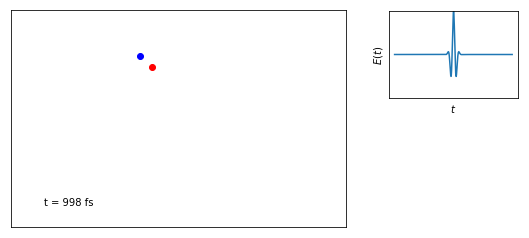

In [3]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time

import numpy as np

########################################################
############## Major Changes ###########################
########################################################
def calc_accel(x,y,efield):
    ax = 4*epso*(Ro**4)/(M*x**5) - 4*epso*(Ro**4)/(M*(L-x)**5)
    ay = 4*epso*(Ro**4)/(M*y**5) - 4*epso*(Ro**4)/(M*(L-y)**5)
    for p1 in range(0, Npart):
        for p2 in range(0,Npart):
            # Check that p1 and p2 are not in the same molecule
            if p1!=p2 and abs(p1-p2)!=Npos:
                rX = x[p1] - x[p2]
                rY = y[p1] - y[p2]
                r = math.sqrt(rX*rX + rY*rY)
                ax[p1] += Q[p1]*Q[p2]*rX/(M*r**3)
                ay[p1] += Q[p1]*Q[p2]*rY/(M*r**3)
                ax[p1] += 12.0*epso*rX*(Ro**12)/(M*r**14) - 12.0*epso*rX*(Ro**6)/(M*r**8)
                ay[p1] += 12.0*epso*rY*(Ro**12)/(M*r**14) - 12.0*epso*rY*(Ro**6)/(M*r**8)
    ay += Q*efield/M
    
    # Acceleration from bonding interactions
    for m in range(0, Npos):
        rX = x[m] - x[m+Npos]
        rY = y[m] - y[m+Npos]
        r = math.sqrt(rX*rX + rY*rY)
        ax[m] -= (K/M)*(r-Rbond)*(rX/r)
        ay[m] -= (K/M)*(r-Rbond)*(rY/r)
        ax[m+Npos] += (K/M)*(r-Rbond)*(rX/r)
        ay[m+Npos] += (K/M)*(r-Rbond)*(rY/r)    
    return ax,ay
########################################################
########################################################


def vv_step(x,y,vx,vy,ax,ay,efield):
    axrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart))/M
    ayrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart))/M
    xnew = x + B*dt*vx + 0.5*B*dt*dt*(ax + axrand)
    ynew = y + B*dt*vy + 0.5*B*dt*dt*(ay + ayrand)
    axnew,aynew = calc_accel(xnew,ynew,efield)
    vxnew = A*vx + 0.5*dt*(A*ax + axnew + 2.0*B*axrand)
    vynew = A*vy + 0.5*dt*(A*ay + aynew + 2.0*B*ayrand)
    return xnew,ynew,vxnew,vynew,axnew,aynew


def init_plot():
    fig = plt.figure(1)
    ax1 = plt.clf()
    txt = plt.text(0.1*L,0.1*L,'t = '+str(round(0))+' fs')
    negLine, = plt.plot(X[0:Npos],Y[0:Npos],'bo')
    posLine, = plt.plot(X[Npos:],Y[Npos:],'ro')
    plt.xlim([0,L])
    plt.ylim([0,L])
    plt.xticks([]) 
    plt.yticks([]) 
    
    ax2 = plt.axes([1.0,0.575,0.3,0.3])
    plt.xlabel('$t$')
    plt.ylabel('$E(t)$')
    field_line, = plt.plot(taxis,Efield)
    plt.xticks([])
    plt.yticks([])
    plt.ylim([0,1])
    plt.ylim([0,dt*Nsteps])
    return fig,ax1,ax2,negLine,posLine,txt,field_line

def update_plot(n):
    negPts.set_ydata(Y[0:Npos])
    negPts.set_xdata(X[0:Npos])
    posPts.set_ydata(Y[Npos:])
    posPts.set_xdata(X[Npos:])
    txt.set_text('t = '+str(round(n*dt*1e+15))+' fs')
    
    plt.sca(ax2)
    #plt.plot(taxis[0:n]/Emax, 'k.')
    field_line.set_xdata(taxis[0:n])
    field_line.set_ydata(Efield[0:n]/Emax)
    plt.ylim([-1,1])
    #plt.xlim([0,dt*Nsteps])
    
    fig.canvas.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
def gauss_pulse(t):
    return Emax*np.cos(2.0*math.pi*(t-to)*nu)*np.exp(-((t-to)**2)/(2.0*sigma*sigma))

epso = 190.0*(1.38064852e-23)*(1e+3)*(1e+4)
Ro = 5.0e-8

L = 0.2e-6
to = 500e-15
sigma = 20e-15
nu = 20e+12
Emax = 100e+4   # Maximum electric field in statV/cm

tmax=1e-12      # Total simulation time in seconds
dt=1e-15     # Time-step in seconds
Nsteps=int(round(tmax/dt))
M=12*(1.66054e-24)   # Mass in g
Qo = 4.803e-10         # Elementary charge in statCoulombs
taxis = np.arange(0,tmax,dt)   # Time axis (array of time steps)

gamma = 1e-12  # grams/second
kB = 1.38064852e-16                  # erg/K
Temp = 300                           # K
B = 1.0/(1.0 + 0.5*gamma*dt/M)
A = B*(1.0 - 0.5*gamma*dt/M)

########################################################
############## Major Changes ###########################
Npos = 1
Npart = 2*Npos
Q = np.zeros((Npart))
Q[0:Npos] = +0.5*Qo    # First Npos particles are positive
Q[Npos:] = -0.5*Qo     # Last Nneg particles are negative
Rbond = 1.24e-8
wo = 6.28*35e12        # Oscillator (angular) frequency
K = M*wo**2

# Generate a vector of random molecule positions
Rx = 0.1*L + np.random.random((Npos))*0.8*L
Ry = 0.1*L + np.random.random((Npos))*0.8*L

# Generate random orientations between 0 and 2*pi radians
Theta = np.random.random((Npos))*2.0*math.pi
#Theta = np.ones((Npos))*math.pi*0.5

# Generate positions for positive and negative atoms in each molecule
# Note: X[n] and X[n+Npos] are bonded pairs! (Same with Y[n] and Y[n+Npos].)
X = np.concatenate((Rx+0.5*Rbond*np.cos(Theta),Rx-0.5*Rbond*np.cos(Theta)))
Y = np.concatenate((Ry+0.5*Rbond*np.sin(Theta),Ry-0.5*Rbond*np.sin(Theta)))

VX = np.zeros((Npart))
VY = np.zeros((Npart))
########################################################
########################################################

# Generate the pulse profile
Efield = gauss_pulse(taxis)

# Calculate accelerations at initial positions
AX,AY = calc_accel(X,Y,Efield[0])

fig,ax1,ax2,negPts,posPts,txt,field_line = init_plot()
for n in range(0,Nsteps):
    X,Y,VX,VY,AX,AY = vv_step(X,Y,VX,VY,AX,AY,Efield[n])
    if(n%2==0):
        update_plot(n)
        

4. Run a simulation with a single molecule in a 2 nm box with a pulse frequency of $\nu = 4$ THz. What kind of motion does the molecule exhibit after the pulse? What kind of spectroscopy does this represent? 

5. Now repeat the simulation with $\nu = 50$ THz. What kind of motion does this initiate? What kind of spectroscopy does this correspond to? 

## The Polarization Density ##

We learned in lecture that molecular spectroscopy is primarily a study of the response of the polarization density ${\bf P}({\bf x},t)$ to the electric field. In this section, we'll calculate the polarization for a "mini-ensemble" of dipoles subjected to an external field. By "mini-ensemble," of course, we just mean a large number of dipoles with random initial conditions placed in a simulation box in such a way that (for the most part) they don't interact with each other. The code below runs a simulation with such a mini-ensemble and then plots the polarization along the $y$-axis (i.e. the average $y$ component of the dipole moment) as a function of time. 

Aside from changing parameter values and plotting the polarization, the only new addition to this code is the introduction of the function ``place_mols()`` that places molecules in the simulation box a bit more carefully. The new function places molecules randomly in the box just like always, but (to avoid instability) it then checks to make sure that molecules aren't too close to each other; it repeats this process a large number of times, exiting either when it successfully places the molecules stably in the box or when it reaches the maximum number of allowed iterations. Note that the *only* reason for adding this function is to allow us to place more particles in the box without causing our simulation to blow up. 

After looking through the code, run it and answer the questions. 

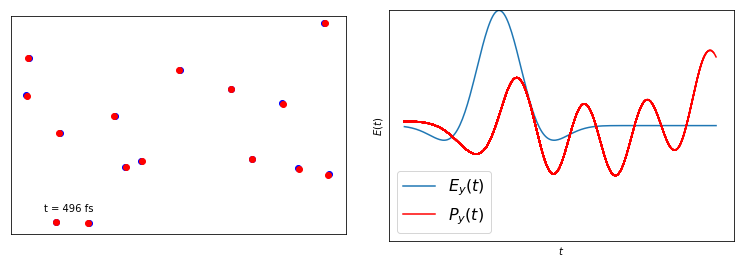

In [4]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import numpy as np

def calc_accel(x,y,efield):
    ax = 4*epso*(Ro**4)/(M*x**5) - 4*epso*(Ro**4)/(M*(L-x)**5)
    ay = 4*epso*(Ro**4)/(M*y**5) - 4*epso*(Ro**4)/(M*(L-y)**5)
    for p1 in range(0, Npart):
        for p2 in range(0,Npart):
            # Check that p1 and p2 are not in the same molecule
            if p1!=p2 and abs(p1-p2)!=Npos:
                rX = x[p1] - x[p2]
                rY = y[p1] - y[p2]
                r = math.sqrt(rX*rX + rY*rY)
                ax[p1] += Q[p1]*Q[p2]*rX/(M*r**3)
                ay[p1] += Q[p1]*Q[p2]*rY/(M*r**3)
                ax[p1] += 12.0*epso*rX*(Ro**12)/(M*r**14) - 12.0*epso*rX*(Ro**6)/(M*r**8)
                ay[p1] += 12.0*epso*rY*(Ro**12)/(M*r**14) - 12.0*epso*rY*(Ro**6)/(M*r**8)
    ay += Q*efield/M
    
    # Acceleration from bonding interactions
    for m in range(0, Npos):
        rX = x[m] - x[m+Npos]
        rY = y[m] - y[m+Npos]
        r = math.sqrt(rX*rX + rY*rY)
        ax[m] -= (K/M)*(r-Rbond)*(rX/r)
        ay[m] -= (K/M)*(r-Rbond)*(rY/r)
        ax[m+Npos] += (K/M)*(r-Rbond)*(rX/r)
        ay[m+Npos] += (K/M)*(r-Rbond)*(rY/r)    
    return ax,ay


def vv_step(x,y,vx,vy,ax,ay,efield):
    axrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart))/M
    ayrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart))/M
    xnew = x + B*dt*vx + 0.5*B*dt*dt*(ax + axrand)
    ynew = y + B*dt*vy + 0.5*B*dt*dt*(ay + ayrand)
    axnew,aynew = calc_accel(xnew,ynew,efield)
    vxnew = A*vx + 0.5*dt*(A*ax + axnew + 2.0*B*axrand)
    vynew = A*vy + 0.5*dt*(A*ay + aynew + 2.0*B*ayrand)
    return xnew,ynew,vxnew,vynew,axnew,aynew


def init_plot():
    fig = plt.figure(1)
    ax1 = plt.clf()
    txt = plt.text(0.1*L,0.1*L,'t = '+str(round(0))+' fs')
    negLine, = plt.plot(X[0:Npos],Y[0:Npos],'bo')
    posLine, = plt.plot(X[Npos:],Y[Npos:],'ro')
    plt.xlim([0,L])
    plt.ylim([0,L])
    plt.xticks([]) 
    plt.yticks([]) 
    
    ax2 = plt.axes([1.0,0.1,0.8,0.8])
    plt.xlabel('$t$')
    plt.ylabel('$E(t)$')
    field_line, = plt.plot(taxis,Efield)
    plt.xticks([])
    plt.yticks([])
    plt.ylim([0,1])
    plt.ylim([0,dt*Nsteps])
    return fig,ax1,ax2,negLine,posLine,txt,field_line

def update_plot(n):
    negPts.set_ydata(Y[0:Npos])
    negPts.set_xdata(X[0:Npos])
    posPts.set_ydata(Y[Npos:])
    posPts.set_xdata(X[Npos:])
    txt.set_text('t = '+str(round(n*dt*1e+15))+' fs')
    
    plt.sca(ax2)
    #plt.plot(taxis[0:n]/Emax, 'k.')
    field_line.set_xdata(taxis[0:n])
    field_line.set_ydata(Efield[0:n]/Emax)
    plt.ylim([-1,1])
    #plt.xlim([0,dt*Nsteps])
    
    fig.canvas.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
def gauss_pulse(t):
    return Emax*np.cos(2.0*math.pi*(t-to)*nu)*np.exp(-((t-to)**2)/(2.0*sigma*sigma))


###############################################################
################### Main Addition #############################
###############################################################
def place_mols():
    Nmols = Npos
    MaxIt = 10000
    minDist = 1.5*Ro
    it = 0
    NoGood = 1
    print("Trying to place molecules...")
    while NoGood==1 and it<MaxIt:
        NoGood = 0
        Rx = minDist + np.random.random((Nmols))*(L-2*minDist)
        Ry = minDist + np.random.random((Nmols))*(L-2*minDist)
        for m1 in range(0,Nmols):
            for m2 in range(0,Nmols):
                r = math.sqrt( (Rx[m1] - Rx[m2])**2 + (Ry[m1] - Ry[m2])**2)
                if m1!=m2 and r < minDist:
                    NoGood = 1
        it += 1
    if NoGood==1:
        print("Sorry, couldn't place so many molecules in so small a box")
        raise
    else:
        return Rx,Ry
###############################################################
###############################################################
    
epso = 190.0*(1.38064852e-23)*(1e+3)*(1e+4)
Ro = 5.0e-8

L = 4e-6
to = 150e-15
sigma = 50e-15
nu = 4e+12
Emax = 100e+4   # Maximum electric field in statV/cm

tmax=0.5e-12      # Total simulation time in seconds
dt=2e-15     # Time-step in seconds
Nsteps=int(round(tmax/dt))
M=12*(1.66054e-24)   # Mass in g
Qo = 4.803e-10         # Elementary charge in statCoulombs
taxis = np.arange(0,tmax,dt)   # Time axis (array of time steps)

gamma = 1e-12  # grams/second
kB = 1.38064852e-16                  # erg/K
Temp = 300                           # K
B = 1.0/(1.0 + 0.5*gamma*dt/M)
A = B*(1.0 - 0.5*gamma*dt/M)

Npos = 15
Npart = 2*Npos
Q = np.zeros((Npart))
Q[0:Npos] = +0.5*Qo    # First Npos particles are positive
Q[Npos:] = -0.5*Qo     # Last Nneg particles are negative
Rbond = 1.24e-8
wo = 6.28*35e12        # Oscillator (angular) frequency
K = M*wo**2

# Generate a vector of random molecule positions
Rx, Ry = place_mols()

# Generate random orientations between 0 and 2*pi radians
Theta = np.random.random((Npos))*2.0*math.pi
#Theta = np.ones((Npos))*math.pi*0.5

# Generate positions for positive and negative atoms in each molecule
# Note: X[n] and X[n+Npos] are bonded pairs! (Same with Y[n] and Y[n+Npos].)
X = np.concatenate((Rx+0.5*Rbond*np.cos(Theta),Rx-0.5*Rbond*np.cos(Theta)))
Y = np.concatenate((Ry+0.5*Rbond*np.sin(Theta),Ry-0.5*Rbond*np.sin(Theta)))

VX = np.zeros((Npart))
VY = np.zeros((Npart))

# Generate the pulse profile
Efield = gauss_pulse(taxis)

# Calculate accelerations at initial positions
AX,AY = calc_accel(X,Y,Efield[0])

MuY = np.zeros((Nsteps))
fig,ax1,ax2,negPts,posPts,txt,field_line = init_plot()
for n in range(0,Nsteps):
    X,Y,VX,VY,AX,AY = vv_step(X,Y,VX,VY,AX,AY,Efield[n])
    MuY[n] = np.sum(Y*Q)
    if(n%2==0):
        update_plot(n)
        plt.plot(taxis[0:n], MuY[0:n]/(0.5*Qo*Rbond*Npos), 'r')
        plt.legend(['$E_y(t)$', '$P_y(t)$'], fontsize=16)

#plt.plot(taxis, MuY/(Q[0]*Rbond*Npos), 'r')

6. Run a few simulations with various frequencies (including at minimum $\nu = 4$ and $\nu = 50$ THz) and either 5 or 100 molecules. If you repeat a simulation with the same parameters, does the polarization vary more run-to-run with the smaller or larger number of molecules? Why? 

7. With 100 molecules, compare the *magnitude* of the induced polarization when $\nu = 4$, $20$, or $50$ THz. When is the response *smallest*? Why? 

8. Run simulations with $\nu = 50$ THz and both $\gamma = 1$ pg/s and $\gamma = 200$ pg/s. How does changing the value of $\gamma$ change the polarization curve? 

# Homework #

### Compute ###
 
1. In a new Jupyter Notebook, use the last simulation cell as a starting point to write a simulation with an ensemble of oscillators with *random frequencies*. Keep the average frequency ``wo`` the same as in the last simulation, but use the ``np.random.normal()`` function to generate a range of frequencies with a standard deviation of ``0.1*wo``. 

2. Using your new program, run a simulation with 100 molecules, a pulse frequency of $\nu = 50$ THz, a pulse width of $\sigma = 10$ fs, and a maximum field strength of $E_{\text{max}} = 3\cdot 10^6$ statV/cm. Compare the behavior of the polarization density ${\bf P}(t)$ in the simulation with and without randomized frequencies. In which case does the induced polarization decay more quickly? Why do you think this happens? Is this an example of dissipation or dephasing? 

### Calculate ###

We've already encountered Taylor series expansions a few times in class, and we'll encounter them again next week when we discuss response theory. Recall that the Taylor series expansion for a function $f(x)$ is given by the formula
\begin{align}
f(x) = \sum_{n=0}^\infty \frac{x^n}{n!} \left . \frac{d^n f}{dx^n} \right |_{x=0} = f(0) + x \cdot f'(0) + \frac{x^2}{2} f''(0) + \frac{x^3}{6} f'''(0) + ... .
\end{align}
Compute the first three terms in this series for $f(x) = \frac{1}{1-x}$. (Show your work!) Can you guess the rest of the series? (For context, this is the series upon which the multipole expansion is based; in this case $x$ represents the ratio of large and small distance scales, e.g., a small charge-to-charge distance and a large charge-to-observer distance).



### Contemplate ###

Amide I spectroscopy involves infrared excitation of the C=O stretch motion of the amide backbone of peptides and proteins. Suppose we wanted to model numerically the interaction of a protein with an ultrafast laser pulse with a frequency of 50 THz (resonant with the C=O stretch). How important would it be in this simulation to properly describe the rotational motion of the protein? Would your answer be different if the system being studied were carbon monoxide instead? 



# Extra Credit #

For extra credit this week, submit all homework answers as a single ipynb file, using Markdown/Latex to code the equations. All submissions that consist of only a single ipynb file will be considered for extra credit, with points assigned based on the readability, simplicity, and elegance of the formatting. 